In [1]:
import pandas as pd
from sklearn.mixture import GaussianMixture

df = pd.read_csv("dataset.csv", index_col=0)
df.rename(columns={'Real': 'Prediction', '40':'SpoofType', '41':'Illumination', '42':'Environment', '43':'Spoof'}, inplace=True)
# the prediction by silent face takes values 0-2. Gotta convert it.
df['Prediction'] = df['Prediction'].replace({0.0: 1, 1.0: 0, 2.0: 1})
df['Prediction'] = df['Prediction'].astype(int)

embeddings = pd.read_csv('dropout_embeddings.csv', index_col=0)

df = df.drop_duplicates()
common_index = df.index.intersection(embeddings.index)
df = df.loc[common_index]
embeddings = embeddings.loc[common_index]

pd.testing.assert_series_equal(df.index.to_series(), embeddings.index.to_series())


gmm = GaussianMixture(n_components=5, random_state=42)
clusters = gmm.fit_predict(embeddings)

embeddings['Spoof'] = df['Spoof']
embeddings['Cluster'] = clusters
embeddings['Illumination'] = df['Illumination']

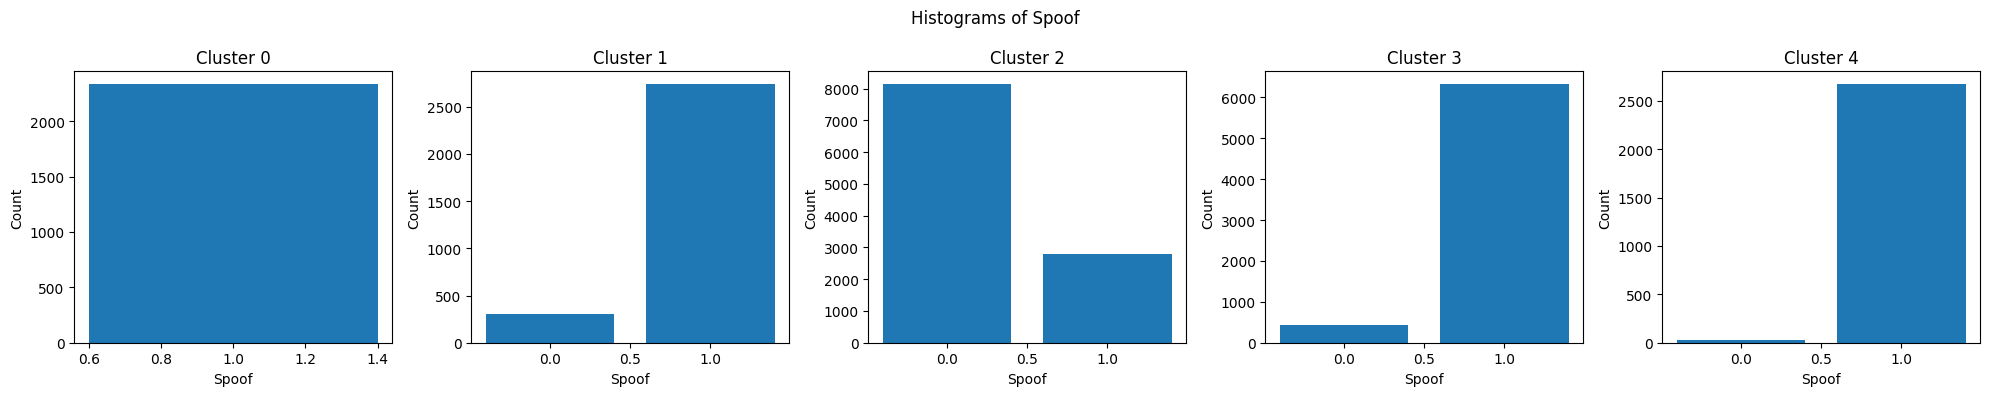

In [49]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Create a histogram for each cluster
for cluster_id, group in embeddings.groupby('Cluster'):
    # Count the frequency of each value of the current feature in the current cluster
    counts = group["Spoof"].value_counts()

    # Create a bar chart of the counts in the current subplot
    axs[cluster_id].bar(counts.index, counts.values)
    axs[cluster_id].set_xlabel("Spoof")
    axs[cluster_id].set_ylabel("Count")
    axs[cluster_id].set_title(f"Cluster {cluster_id}")

# Add a title to the overall plot
plt.suptitle("Histograms of Spoof")

# Adjust the layout of the subplots
plt.tight_layout()

# Display the overall plot
plt.show()

In [42]:
# # Separate source and target domain data
# source_df = embeddings[(embeddings['Cluster'] == 2) | (embeddings['Cluster'] == 3)]
# target_df = embeddings[(embeddings['Cluster'] != 2) & (embeddings['Cluster'] != 3)]
# source_df = embeddings[embeddings['Cluster'] == 2]
# target_df = embeddings[embeddings['Cluster'] != 2]
import numpy as np
num_rows = len(embeddings)

# Generate random 0s and 1s
random_zeros_ones = np.random.randint(0, 2, size=num_rows)

# Add the random column to the dataframe
embeddings['RandomBinary'] = random_zeros_ones
source_df = embeddings[embeddings['RandomBinary'] == 0]
target_df = embeddings[embeddings['RandomBinary'] != 1]

In [43]:
import torch
from torch.utils.data import Dataset, DataLoader

class EmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.embeddings = dataframe.drop(columns=['Cluster', 'Spoof', 'Illumination', 'RandomBinary']).values
        self.cluster = dataframe['Cluster'].values
        self.spoof = dataframe['Spoof'].values
    
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        embeddings = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        cluster = torch.tensor(self.cluster[idx], dtype=torch.long)
        spoof = torch.tensor(self.spoof[idx], dtype=torch.long)
        return embeddings, cluster, spoof

# # Create PyTorch Datasets
# source_dataset = EmbeddingDataset(source_df)
# target_dataset = EmbeddingDataset(target_df)

# # Create DataLoaders
# source_loader = DataLoader(source_dataset, batch_size=64)
# target_loader = DataLoader(target_dataset, batch_size=64)

In [91]:
import torch
import torch.nn as nn

# Define Encoder and BinClass with dropout
class Encoder(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Encoder, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )

    def forward(self, x):
        return self.stack(x)

class BinClass(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(BinClass, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.stack(x)
    
class Discriminator(nn.Module):
    def __init__(self, dropout_rate = 0.1):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        return self.layer2(x)

In [83]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import os
from sklearn.metrics import roc_auc_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.model_selection import train_test_split

def pretrain_source_encoder_classifier(source_df, test_size=0.2, num_epochs=10, batch_size=64, save_path='models'):
    train_df, val_df = train_test_split(source_df, test_size=test_size, random_state=42, stratify=source_df['Cluster'])
    os.makedirs(save_path, exist_ok=True)

    train_dataset = EmbeddingDataset(train_df)
    val_dataset = EmbeddingDataset(val_df)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize models
    source_encoder = Encoder(dropout_rate=0.5).to(device)
    classifier = BinClass(dropout_rate=0.5).to(device)

    # Initialize optimizers
    optimizer_source = optim.Adam(source_encoder.parameters(), lr=1e-2)
    optimizer_classifier = optim.Adam(classifier.parameters(), lr=1e-2)

    best_roc_auc = 0
    best_encoder_state_dict = None
    best_classifier_state_dict = None

    for epoch in range(num_epochs):
        source_encoder.train()
        classifier.train()

        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for embed, clust, spoof in train_loader:
            embed, clust, spoof = embed.to(device), clust.to(device), spoof.to(device)

            optimizer_source.zero_grad()
            optimizer_classifier.zero_grad()
            
            encodings = source_encoder(embed)
            spoof_pred = classifier(encodings)

            loss = F.cross_entropy(spoof_pred, spoof)
            loss.backward()

            optimizer_source.step()
            optimizer_classifier.step()

            running_loss += loss.item() * embed.size(0)
            _, predicted = torch.max(spoof_pred.data, 1)
            correct_predictions += (predicted == spoof).sum().item()
            total_predictions += spoof.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_predictions / total_predictions 

        source_encoder.eval()
        classifier.eval()
        val_loss = 0.0
        correct_val_predictions = 0
        total_val_predictions = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for embed, clust, spoof in val_loader:
                embed, clust, spoof = embed.to(device), clust.to(device), spoof.to(device)
                encodings = source_encoder(embed)
                spoof_pred = classifier(encodings)

                loss = F.cross_entropy(spoof_pred, spoof)
                val_loss += loss.item() * embed.size(0)
                _, predicted = torch.max(spoof_pred.data, 1)
                correct_val_predictions += (predicted == spoof).sum().item()
                total_val_predictions += spoof.size(0)

                all_labels.extend(spoof.cpu().numpy())
                all_predictions.extend(spoof_pred[:, 1].cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_roc_auc = roc_auc_score(all_labels, all_predictions)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")

        if val_roc_auc > best_roc_auc:
            best_roc_auc = val_roc_auc
            best_encoder_state_dict = source_encoder.state_dict()
            best_classifier_state_dict = classifier.state_dict()

    encoder_save_path = os.path.join(save_path, 'source_encoder.pth')
    classifier_save_path = os.path.join(save_path, 'classifier.pth')
    torch.save(best_encoder_state_dict, encoder_save_path)
    torch.save(best_classifier_state_dict, classifier_save_path)
    print(f"New best model saved with ROC AUC: {best_roc_auc:.4f}")

pretrain_source_encoder_classifier(source_df=source_df)


Epoch [1/10], Train Loss: 0.5129, Train Accuracy: 0.7473, Val Loss: 0.4837, Val Accuracy: 0.7339, Val ROC AUC: 0.7928
Epoch [2/10], Train Loss: 0.5073, Train Accuracy: 0.7519, Val Loss: 0.4906, Val Accuracy: 0.7398, Val ROC AUC: 0.7980
Epoch [3/10], Train Loss: 0.5069, Train Accuracy: 0.7487, Val Loss: 0.5025, Val Accuracy: 0.7334, Val ROC AUC: 0.7537
Epoch [4/10], Train Loss: 0.5091, Train Accuracy: 0.7463, Val Loss: 0.4883, Val Accuracy: 0.7334, Val ROC AUC: 0.8043
Epoch [5/10], Train Loss: 0.5094, Train Accuracy: 0.7465, Val Loss: 0.5058, Val Accuracy: 0.7334, Val ROC AUC: 0.8016
Epoch [6/10], Train Loss: 0.5011, Train Accuracy: 0.7457, Val Loss: 0.4688, Val Accuracy: 0.7412, Val ROC AUC: 0.8110
Epoch [7/10], Train Loss: 0.5038, Train Accuracy: 0.7454, Val Loss: 0.4532, Val Accuracy: 0.7334, Val ROC AUC: 0.8466
Epoch [8/10], Train Loss: 0.4884, Train Accuracy: 0.7470, Val Loss: 0.4642, Val Accuracy: 0.7366, Val ROC AUC: 0.8108
Epoch [9/10], Train Loss: 0.5015, Train Accuracy: 0.7502

Epoch [1/20], Target Train Loss: 0.5725, Discriminator Train Loss: 1.2156, Discriminator Train Accuracy: 0.5008, Discriminator Val Loss: 1.2310, Discriminator Val Accuracy: 0.5064, Val ROC AUC: 0.0087
Epoch [2/20], Target Train Loss: 0.5623, Discriminator Train Loss: 1.2143, Discriminator Train Accuracy: 0.5012, Discriminator Val Loss: 1.2240, Discriminator Val Accuracy: 0.5064, Val ROC AUC: 0.0082
Epoch [3/20], Target Train Loss: 0.5618, Discriminator Train Loss: 1.2067, Discriminator Train Accuracy: 0.5017, Discriminator Val Loss: 1.2156, Discriminator Val Accuracy: 0.5067, Val ROC AUC: 0.0165
Epoch [4/20], Target Train Loss: 0.5620, Discriminator Train Loss: 1.1986, Discriminator Train Accuracy: 0.5027, Discriminator Val Loss: 1.2066, Discriminator Val Accuracy: 0.5071, Val ROC AUC: 0.0394
Epoch [5/20], Target Train Loss: 0.5619, Discriminator Train Loss: 1.1907, Discriminator Train Accuracy: 0.5073, Discriminator Val Loss: 1.1996, Discriminator Val Accuracy: 0.5073, Val ROC AUC: 0.

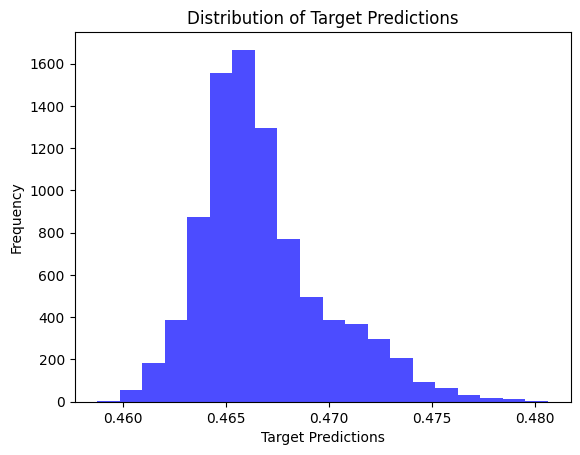

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train_target_encoder_discriminator(source_df, target_df, test_size=0.2, num_epochs=20, batch_size=64, target_encoder_iterations = 2, save_path='models'):
    # Create the save directory if it does not exist
    os.makedirs(save_path, exist_ok=True)
    
    # Split the datasets
    source_train_df, source_val_df = train_test_split(source_df, test_size=test_size, random_state=42)
    target_train_df, target_val_df = train_test_split(target_df, test_size=test_size, random_state=42)

    # Create datasets
    source_train_dataset = EmbeddingDataset(source_train_df)
    source_val_dataset = EmbeddingDataset(source_val_df)
    target_train_dataset = EmbeddingDataset(target_train_df)
    target_val_dataset = EmbeddingDataset(target_val_df)
    
    # Create data loaders
    source_train_loader = DataLoader(source_train_dataset, batch_size=batch_size, shuffle=True)
    source_val_loader = DataLoader(source_val_dataset, batch_size=batch_size, shuffle=False)
    target_train_loader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True)
    target_val_loader = DataLoader(target_val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize and load pre-trained models
    source_encoder = Encoder(dropout_rate=0.5).to(device)
    classifier = BinClass(dropout_rate=0.1).to(device)
    source_encoder.load_state_dict(torch.load('models/source_encoder.pth'))
    classifier.load_state_dict(torch.load('models/classifier.pth'))

    source_encoder.eval()
    classifier.eval()
    # I am initializing the target_encoder as the source encoder to reduce degenerate conversion
    target_encoder = Encoder(dropout_rate=0.5).to(device)
    target_encoder.load_state_dict(torch.load('models/source_encoder.pth'))
    discriminator = Discriminator().to(device)

    optimizer_target_encoder = optim.Adam(target_encoder.parameters(), lr=1e-2, weight_decay=0.1)
    optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-5, weight_decay=0.1)

    criterion_bce = nn.BCELoss()

    best_roc_auc = 0.0
    best_target_encoder_state_dict = None
    best_discriminator_state_dict = None

    for epoch in range(num_epochs):
        target_encoder.train()
        discriminator.train()

        running_loss_target = 0.0
        running_loss_discriminator = 0.0
        correct_predictions_discriminator = 0
        total_predictions_discriminator = 0

        target_preds_distribution = []

        for (source_embed, _, _), (target_embed, _, _) in zip(source_train_loader, target_train_loader):
            source_embed = source_embed.to(device)
            target_embed = target_embed.to(device)

            optimizer_discriminator.zero_grad()
            optimizer_target_encoder.zero_grad()
            
            # Train Discriminator
            source_encodings = source_encoder(source_embed)
            target_encodings = target_encoder(target_embed)

            source_labels = torch.ones(source_encodings.size(0), 1).to(device)
            target_labels = torch.zeros(target_encodings.size(0), 1).to(device)

            source_preds = discriminator(source_encodings)
            target_preds = discriminator(target_encodings)

            target_preds_distribution.extend(target_preds.cpu().detach().numpy().flatten())

            discriminator_loss = criterion_bce(source_preds, source_labels) + criterion_bce(target_preds, target_labels)
            discriminator_loss.backward()
            optimizer_discriminator.step()

            running_loss_discriminator += discriminator_loss.item() * (source_embed.size(0) + target_embed.size(0))
            correct_predictions_discriminator += (torch.round(source_preds) == source_labels).sum().item() + \
                                                 (torch.round(target_preds) == target_labels).sum().item()
            total_predictions_discriminator += source_labels.size(0) + target_labels.size(0)

            # Train Target Encoder to fool Discriminator
            # for _ in range(target_encoder_iterations):
            target_encodings = target_encoder(target_embed)
            target_preds = discriminator(target_encodings)

            target_labels = torch.ones(target_encodings.size(0), 1).to(device)
            target_encoder_loss = criterion_bce(target_preds, target_labels)
            target_encoder_loss.backward()
            optimizer_target_encoder.step()

            running_loss_target += target_encoder_loss.item() * target_embed.size(0)

        train_loss_target = running_loss_target / len(target_train_loader.dataset)
        train_loss_discriminator = running_loss_discriminator / (len(source_train_loader.dataset) + len(target_train_loader.dataset))
        train_accuracy_discriminator = correct_predictions_discriminator / total_predictions_discriminator

        # Validation Phase
        target_encoder.eval()
        discriminator.eval()

        val_loss_discriminator = 0.0
        correct_val_predictions_discriminator = 0
        total_val_predictions_discriminator = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for (source_embed, _, _), (target_embed, _, _) in zip(source_val_loader, target_val_loader):
                source_embed = source_embed.to(device)
                target_embed = target_embed.to(device)

                source_encodings = source_encoder(source_embed)
                target_encodings = target_encoder(target_embed)

                source_labels = torch.ones(source_encodings.size(0), 1).to(device)
                target_labels = torch.zeros(target_encodings.size(0), 1).to(device)

                source_preds = discriminator(source_encodings)
                target_preds = discriminator(target_encodings)

                val_loss_discriminator += (criterion_bce(source_preds, source_labels).item() + 
                                           criterion_bce(target_preds, target_labels).item()) * (source_embed.size(0) + target_embed.size(0))
                correct_val_predictions_discriminator += (torch.round(source_preds) == source_labels).sum().item() + \
                                                         (torch.round(target_preds) == target_labels).sum().item()
                total_val_predictions_discriminator += source_labels.size(0) + target_labels.size(0)

                all_labels.extend(source_labels.cpu().numpy())
                all_predictions.extend(source_preds.cpu().numpy())
                all_labels.extend(target_labels.cpu().numpy())
                all_predictions.extend(target_preds.cpu().numpy())

        val_loss_discriminator /= (len(source_val_loader.dataset) + len(target_val_loader.dataset))
        val_accuracy_discriminator = correct_val_predictions_discriminator / total_val_predictions_discriminator
        val_roc_auc = roc_auc_score(all_labels, all_predictions)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Target Train Loss: {train_loss_target:.4f}, Discriminator Train Loss: {train_loss_discriminator:.4f}, "
              f"Discriminator Train Accuracy: {train_accuracy_discriminator:.4f}, Discriminator Val Loss: {val_loss_discriminator:.4f}, "
              f"Discriminator Val Accuracy: {val_accuracy_discriminator:.4f}, Val ROC AUC: {val_roc_auc:.4f}")

        if val_roc_auc > best_roc_auc:
            best_roc_auc = val_roc_auc
            best_target_encoder_state_dict = target_encoder.state_dict()
            best_discriminator_state_dict = discriminator.state_dict()
    target_encoder_save_path = os.path.join(save_path, 'target_encoder.pth')
    discriminator_save_path = os.path.join(save_path, 'discriminator.pth')
    torch.save(best_target_encoder_state_dict, target_encoder_save_path)
    torch.save(best_discriminator_state_dict, discriminator_save_path)
    print(f"New best model saved with ROC AUC: {best_roc_auc:.4f}")


    plt.hist(target_preds_distribution, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Target Predictions')
    plt.ylabel('Frequency')
    plt.title('Distribution of Target Predictions')
    plt.show()


# Example call to the function
train_target_encoder_discriminator(source_df=source_df, target_df=target_df)

In [112]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np


def load_model(model_class, path, dropout_rate=0.5):
    model = model_class(dropout_rate=dropout_rate).to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def evaluate_model(encoder, classifier, dataloader):
    encoder.eval()
    classifier.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for embed, _, label in dataloader:
            embed, label = embed.to(device), label.to(device)
            encodings = encoder(embed)
            outputs = classifier(encodings)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    roc_auc = roc_auc_score(all_labels, all_probs)
    
    return roc_auc

def metrics(
        target_df,
        source_encoder_path = 'models/source_encoder.pth',
        classifier_path = 'models/classifier.pth',
        target_encoder_path = 'models/target_encoder.pth',
        ):
    # Load the target data
    target_dataset = EmbeddingDataset(target_df)
    target_loader = DataLoader(target_dataset, batch_size=64, shuffle=False)

    source_encoder = load_model(Encoder, source_encoder_path)
    classifier = load_model(BinClass, classifier_path)
    target_encoder = load_model(Encoder, target_encoder_path)

    # Evaluate source_encoder + classifier on target data
    print("Evaluating source_encoder + classifier on target data...")
    source_roc_auc = evaluate_model(source_encoder, classifier, target_loader)
    print(f"ROC AUC: {source_roc_auc:.4f}")

    # Evaluate target_encoder + classifier on target data
    print("Evaluating target_encoder + classifier on target data...")
    target_roc_auc = evaluate_model(target_encoder, classifier, target_loader)
    print(f"ROC AUC: {target_roc_auc:.4f}")
    improvement = target_roc_auc/source_roc_auc
    print(f"Relative Improvement: {improvement}")
    return source_roc_auc, target_roc_auc, improvement

metrics(target_df=target_df)


Evaluating source_encoder + classifier on target data...
ROC AUC: 0.6030
Evaluating target_encoder + classifier on target data...
ROC AUC: 0.5608
Relative Improvement: 0.9300139289290278


(0.602975672533569, 0.5607757742615673, 0.9300139289290278)

In [89]:
def full_train(source_df, target_df):
    # Create PyTorch Datasets
    pretrain_source_encoder_classifier(source_df=source_df)
    train_target_encoder_discriminator(source_df=source_df, target_df=target_df)
    ans = metrics(target_df=target_df)
    return ans

In [90]:
# # # Separate source and target domain data
# source_df = embeddings[embeddings['RandomBinary'] == 0]
# target_df = embeddings[embeddings['RandomBinary'] != 1]
# Separate source and target domain data
source_df = embeddings[embeddings['Cluster'] == 2]
target_df = embeddings[embeddings['Cluster'] != 2]
score = full_train(source_df=source_df, target_df=target_df)

scores = {}
scores['Cluster_2'] = score
# Convert the dictionary to a DataFrame
scores = pd.DataFrame(scores)

# Save the DataFrame as a CSV file
scores.to_csv('scores.csv', index=False)

print("DataFrame has been saved as 'scores.csv'")

Epoch [1/10], Train Loss: 0.5179, Train Accuracy: 0.7413, Val Loss: 0.4793, Val Accuracy: 0.7407, Val ROC AUC: 0.3571
Epoch [2/10], Train Loss: 0.5081, Train Accuracy: 0.7491, Val Loss: 0.4858, Val Accuracy: 0.7334, Val ROC AUC: 0.7984
Epoch [3/10], Train Loss: 0.5055, Train Accuracy: 0.7504, Val Loss: 0.4926, Val Accuracy: 0.7334, Val ROC AUC: 0.2175
Epoch [4/10], Train Loss: 0.4978, Train Accuracy: 0.7516, Val Loss: 0.4725, Val Accuracy: 0.7334, Val ROC AUC: 0.6243
Epoch [5/10], Train Loss: 0.5038, Train Accuracy: 0.7491, Val Loss: 0.4753, Val Accuracy: 0.7412, Val ROC AUC: 0.7430
Epoch [6/10], Train Loss: 0.4986, Train Accuracy: 0.7488, Val Loss: 0.4625, Val Accuracy: 0.7334, Val ROC AUC: 0.8458
Epoch [7/10], Train Loss: 0.4951, Train Accuracy: 0.7552, Val Loss: 0.4903, Val Accuracy: 0.7334, Val ROC AUC: 0.7603
Epoch [8/10], Train Loss: 0.5221, Train Accuracy: 0.7497, Val Loss: 0.5110, Val Accuracy: 0.7334, Val ROC AUC: 0.8067
Epoch [9/10], Train Loss: 0.5027, Train Accuracy: 0.7551